In [1]:
import numpy as np

In [2]:
from blg_strain.hamiltonian import Hfunc

In [3]:
kxlims=[-0.35e9, .35e9]
kylims=[-0.35e9, .35e9]
Nkx, Nky = 1000, 1000

kx = np.linspace(kxlims[0], kxlims[1], Nkx)
ky = np.linspace(kylims[0], kylims[1], Nky)

Kx, Ky = np.meshgrid(kx, ky, indexing='ij')

# Eigenvalues of Hamiltonian
calculating eigenvalues is the slowest step

In [4]:
%%timeit
H = Hfunc(Kx, Ky)
H = H.transpose(2,3,0,1) # put the 4x4 in the last 2 dims for eigh

393 ms ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
H = Hfunc(Kx, Ky)
H = H.transpose(2,3,0,1) # put the 4x4 in the last 2 dims for eigh

In [7]:
%%timeit
E, Psi = np.linalg.eigh(H)  # using eigh for Hermitian
                            # eigenvalues are real and sorted (low to high)
# Shapes - E: Nkx x Nky x 4, Psi: Nkx x Nky x 4 x 4

3.59 s ± 60.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
E, Psi = np.linalg.eigh(H)

In [12]:
%%timeit
E2 = E.transpose(2,0,1) # put the kx,ky points in last 2 dims
Psi2 = Psi.transpose(2,3,0,1) # put the kx,ky points in last 2 dims
# now E[:, 0, 0] is a length-4 array of eigenvalues

579 ns ± 4.96 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [6]:
E = E.transpose(2,0,1) # put the kx,ky points in last 2 dims
Psi = Psi.transpose(2,3,0,1) # put the kx,ky points in last 2 dims

In [16]:
%%timeit
multiplier = 2 * (Psi[0, :, :, :].real > 0) - 1  # shape 4 x Nkx x Nky
Psi2 = Psi* multiplier 
Psi2 = Psi2.transpose((1,0,2,3))

216 ms ± 973 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
multiplier = 2 * (Psi[0, :, :, :].real > 0) - 1  # shape 4 x Nkx x Nky
Psi *= multiplier 
Psi = Psi.transpose((1,0,2,3))

# Berry

In [8]:
from blg_strain.hamiltonian import H_dkx, H_dky

In [9]:
hdkx, hdky = H_dkx(1), H_dky()  # 4x4 matrices

Omega = np.zeros_like(E)  # 4 x Nkx x Nky
Mu = np.zeros_like(E)

In [24]:
%%timeit
psi_n = Psi[0]
psi_m = Psi[1]
prod1 = np.einsum('ijk,il,ljk->jk', psi_n.conj(), hdkx, psi_m)
prod2 = np.einsum('ijk,il,ljk->jk', psi_m.conj(), hdky, psi_n)

396 ms ± 5.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit
Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

77.7 ms ± 501 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
%%timeit
for n, (e_n, psi_n) in enumerate(zip(E, Psi)):
    for m, (e_m, psi_m) in enumerate(zip(E, Psi)):
        if n == m: # sum runs over n != m
            continue

        prod1 = np.einsum('ijk,il,ljk->jk', psi_n.conj(), hdkx, psi_m, optimize=True)
        prod2 = np.einsum('ijk,il,ljk->jk', psi_m.conj(), hdky, psi_n, optimize=True)

        Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
        Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

4.41 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
for n, (e_n, psi_n) in enumerate(zip(E, Psi)):
    for m, (e_m, psi_m) in enumerate(zip(E, Psi)):
        if n == m: # sum runs over n != m
            continue

        prod1 = np.einsum('ijk,il,ljk->jk', psi_n.conj(), hdkx, psi_m)
        prod2 = np.einsum('ijk,il,ljk->jk', psi_m.conj(), hdky, psi_n)

        Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
        Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

Non-looping version:

In [40]:
%%timeit
Enm = E.reshape(4,1, E.shape[-2], E.shape[-1]) - E.reshape(1,4, E.shape[-2], E.shape[-1])
for i in range(4):
    Enm[i,i,:,:] = 1e100 # make diagonal components go to zero when divide by Enm


# compute matrix products then sum the products
prod1 = np.einsum('nikl,ij,mjkl->nmkl', Psi.conj(), hdkx, Psi)
prod2 = np.einsum('mikl,ij,njkl->nmkl', Psi.conj(), hdky, Psi)
Omega = np.sum(np.imag(prod1*prod2/Enm**2), axis=1)  # sum over m
Mu = np.sum(np.imag(prod1*prod2/Enm), axis=1)  # sum over m

10.2 s ± 384 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
Enm = E.reshape(4,1, E.shape[-2], E.shape[-1]) - E.reshape(1,4, E.shape[-2], E.shape[-1])
for i in range(4):
    Enm[i,i,:,:] = 1e100 # make diagonal components go to zero when divide by Enm


# compute matrix products then sum the products
prod1 = np.einsum('nikl,ij,mjkl->nmkl', Psi.conj(), hdkx, Psi)
prod2 = np.einsum('mikl,ij,njkl->nmkl', Psi.conj(), hdky, Psi)
Omega = np.sum(np.imag(prod1*prod2/Enm**2), axis=1)  # sum over m
Mu = np.sum(np.imag(prod1*prod2/Enm), axis=1)  # sum over m

Looping `tensordot` version - memory error!

In [49]:
hdkx, hdky = H_dkx(1), H_dky()  # 4x4 matrices

Omega = np.zeros_like(E)  # 4 x Nkx x Nky
Mu = np.zeros_like(E)

In [ ]:
for n, (e_n, psi_n) in enumerate(zip(E, Psi)):
    for m, (e_m, psi_m) in enumerate(zip(E, Psi)):
        if n == m: # sum runs over n != m
            continue

        prod1 = np.einsum('ijk,il,ljk->jk', psi_n.conj(), hdkx, psi_m)
        prod2 = np.einsum('ijk,il,ljk->jk', psi_m.conj(), hdky, psi_n)

        Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
        Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

In [57]:
prod1 = np.tensordot(psi_n.conj(), hdkx, axes=[[0],[0]])
prod2 = np.tensordot(prod1, psi_m, axes=[[-1],[0]])

MemoryError: 

`opt_einsum` package - no difference using numpy backend

In [12]:
from opt_einsum import contract

In [ ]:
hdkx, hdky = H_dkx(1), H_dky()  # 4x4 matrices

Omega = np.zeros_like(E)  # 4 x Nkx x Nky
Mu = np.zeros_like(E)

In [45]:
%%timeit
Psi_conj = Psi.conj()

for n, (e_n, psi_n, psi_n_conj) in enumerate(zip(E, Psi, Psi_conj)):
    for m, (e_m, psi_m_conj) in enumerate(zip(E, Psi_conj)):
        if n == m: # sum runs over n != m
            continue

        prod1 = contract('ijk,il,ljk->jk', psi_n_conj, hdkx, psi_m, optimize=True)
        prod2 = contract('ijk,il,ljk->jk', psi_m_conj, hdky, psi_n, optimize=True)

        Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
        Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

4.52 s ± 41.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%prun
Psi_conj = Psi.conj()

for n, (e_n, psi_n, psi_n_conj) in enumerate(zip(E, Psi, Psi_conj)):
    for m, (e_m, psi_m_conj) in enumerate(zip(E, Psi_conj)):
        if n == m: # sum runs over n != m
            continue

        prod1 = contract('ijk,il,ljk->jk', psi_n_conj, hdkx, psi_m, optimize=True)
        prod2 = contract('ijk,il,ljk->jk', psi_m_conj, hdky, psi_n, optimize=True)

        Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
        Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

In [16]:
psi_n = Psi[0]
psi_m = Psi[1]

In [17]:
%timeit prod1 = np.einsum('ijk,il,ljk->jk', psi_n.conj(), hdkx, psi_m, optimize=True)
%timeit prod1 = contract('ijk,il,ljk->jk', psi_n.conj(), hdkx, psi_m, optimize=True)

146 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
153 ms ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


tensorflow backend?

In [35]:
import tensorflow as tf

In [30]:
from opt_einsum import contract_expression, contract

In [16]:
psi_n=Psi[0]
psi_m=Psi[1]

In [17]:
expr = contract_expression('ijk,il,ljk->jk', psi_n.shape, hdkx.shape, psi_n.shape)

In [32]:
%%timeit
prod1 = contract('ijk,il,ljk->jk', psi_n.conj().imag, hdkx, psi_m.real, optimize=True, backend='tensorflow')
prod2 = contract('ijk,il,ljk->jk', psi_n.conj().real, hdkx, psi_m.imag, optimize=True, backend='tensorflow')
# prod1 = expr(psi_n.conj().imag, hdkx, psi_m.real, backend='tensorflow')
# prod2 = expr(psi_n.conj().real, hdkx, psi_m.imag, backend='tensorflow')
prod = prod1 + prod2

205 ms ± 3.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Showing real and imaginary parts explicitly, we have
# Imag[(a+bi)*H*(c+di)] = bHc +aHd

removed for loop with tensorflow

In [37]:
%%timeit
Enm = E.reshape(4,1, E.shape[-2], E.shape[-1]) - E.reshape(1,4, E.shape[-2], E.shape[-1])
for i in range(4):
    Enm[i,i,:,:] = 1e100 # make diagonal components go to zero when divide by Enm


# compute matrix products then sum the products

prod1a = contract('nikl,ij,mjkl->nmkl', Psi.conj().imag, hdkx, Psi.real, optimize=True, backend='tensorflow')
prod1b = contract('nikl,ij,mjkl->nmkl', Psi.conj().real, hdkx, Psi.imag, optimize=True, backend='tensorflow')
prod1 = prod1a + prod1b

prod2a = contract('mikl,ij,njkl->nmkl', Psi.conj().imag, hdkx, Psi.real, optimize=True, backend='tensorflow')
prod2b = contract('mikl,ij,njkl->nmkl', Psi.conj().real, hdkx, Psi.imag, optimize=True, backend='tensorflow')
prod2 = prod2a + prod2b


# prod2 = contract('mikl,ij,njkl->nmkl', Psi.conj(), hdky, Psi, backend='tensorflow')
Omega = np.sum(np.imag(prod1*prod2/Enm**2), axis=1)  # sum over m
Mu = np.sum(np.imag(prod1*prod2/Enm), axis=1)  # sum over m

5.01 s ± 441 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%%prun
Enm = E.reshape(4,1, E.shape[-2], E.shape[-1]) - E.reshape(1,4, E.shape[-2], E.shape[-1])
for i in range(4):
    Enm[i,i,:,:] = 1e100 # make diagonal components go to zero when divide by Enm


# compute matrix products then sum the products

prod1a = contract('nikl,ij,mjkl->nmkl', Psi.conj().imag, hdkx, Psi.real, optimize=True, backend='tensorflow')
prod1b = contract('nikl,ij,mjkl->nmkl', Psi.conj().real, hdkx, Psi.imag, optimize=True, backend='tensorflow')
prod1 = prod1a + prod1b

prod2a = contract('mikl,ij,njkl->nmkl', Psi.conj().imag, hdkx, Psi.real, optimize=True, backend='tensorflow')
prod2b = contract('mikl,ij,njkl->nmkl', Psi.conj().real, hdkx, Psi.imag, optimize=True, backend='tensorflow')
prod2 = prod2a + prod2b


# prod2 = contract('mikl,ij,njkl->nmkl', Psi.conj(), hdky, Psi, backend='tensorflow')
Omega = np.sum(np.imag(prod1*prod2/Enm**2), axis=1)  # sum over m
Mu = np.sum(np.imag(prod1*prod2/Enm), axis=1)  # sum over m

In [46]:
%%timeit
Psi_conj = Psi.conj()

for n, (e_n, psi_n, psi_n_conj) in enumerate(zip(E, Psi, Psi_conj)):
    for m, (e_m, psi_m_conj) in enumerate(zip(E, Psi_conj)):
        if n == m: # sum runs over n != m
            continue

        prod1 = np.einsum('ijk,il,ljk->jk', psi_n_conj, hdkx, psi_m, optimize=True)
        prod2 = np.einsum('ijk,il,ljk->jk', psi_m_conj, hdky, psi_n, optimize=True)

        Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
        Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

## rewrite einsum to eliminate for loop?

In [12]:
E.shape

(4, 1000, 1000)

In [14]:
Enm = E.reshape(4,1, E.shape[-2], E.shape[-1]) - E.reshape(1,4, E.shape[-2], E.shape[-1])
Enm.shape

(4, 4, 1000, 1000)

In [21]:
for i in range(4):
    Enm[i,i,:,:] = 1e100
# when dividing by Enm, diagonal components (n=m) will go to zero

In [16]:
# BAD - these sum before multiplying the two inner products
prod1 = np.einsum('nikl,ij,mjkl->kl', Psi.conj(), hdkx, Psi)
prod2 = np.einsum('mikl,ij,njkl->kl', Psi.conj(), hdky, Psi)

In [ ]:
# this takes too long/hangs
prod = np.einsum('nikl,ij,mjkl,nokl,op,mpkl->kl', Psi.conj(), hdkx, Psi, Psi.conj(), hdky, Psi/Enm)

In [49]:
%%prun
# compute matrix products then sum the products
prod1 = np.einsum('nikl,ij,mjkl->nmkl', Psi.conj(), hdkx, Psi)
prod2 = np.einsum('mikl,ij,njkl->nmkl', Psi.conj(), hdky, Psi)
prod = np.sum(np.imag(prod1*prod2/Enm), axis=1)  # sum over m

In [27]:
prod.shape

(4, 1000, 1000)

In [ ]:
Omega2 = np.imag(prod1 * prod2)

In [65]:
E = np.array([1, 2, 3, 4])

In [69]:
E.reshape(4,1)

array([[1],
       [2],
       [3],
       [4]])

In [68]:
E.reshape(4,1) - E.reshape(1,4)

array([[ 0, -1, -2, -3],
       [ 1,  0, -1, -2],
       [ 2,  1,  0, -1],
       [ 3,  2,  1,  0]])

In [ ]:
Omega = np.imag(prod1 * prod2 / )

In [33]:
import matplotlib.pyplot as plt

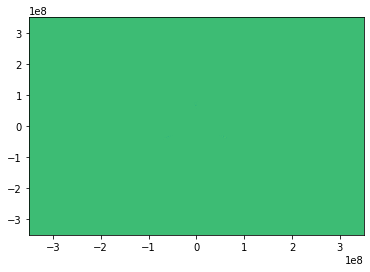

In [36]:
fig, ax = plt.subplots()
ax.pcolormesh(kx, ky, Mu[2])

In [38]:
Mu[0,27,0], prod[0,27,0]

(-2.872962451952862e-34, -2.872962451952862e-34)